In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from scipy import interpolate
import scipy.io as sio
from numpy import *

min_max_scaler = preprocessing.MinMaxScaler()

In [2]:
condition = 'Bearing1'
accs_offset = {'Bearing1_1': 8, 'Bearing1_2': 8, 'Bearing1_3': 0, 'Bearing1_4': 12, 'Bearing1_5': 0}
temps_offset = {'Bearing1_1': 16, 'Bearing1_2': 0, 'Bearing1_3': 0, 'Bearing1_4': 21, 'Bearing1_5': 4}
max_window_stamp = 50
window_size = 40
stride = 25

### Two feature input minmax scalar

In [3]:
train_x = sio.loadmat(f'./Mat_train/{condition}_2d_train_x.mat')['train_x']  # load sliding window preprocessed and Statistical features processed data (mean value and regression coefficient estimates feature)
len_x = len(train_x)
dim_x = train_x.shape[2]
train_x = train_x.reshape(-1, dim_x)
min_max_scaler.fit(train_x)
del train_x

### Three feature input

In [ ]:
train_x = sio.loadmat(f'./Mat_train/{condition}_3d_train_x.mat')['train_x']  # load sliding window preprocessed and Statistical features processed data (mean value and regression coefficient estimates feature)
len_x = len(train_x)
dim_x = train_x.shape[2]
train_x = train_x.reshape(-1, dim_x)
min_max_scaler.fit(train_x)
del train_x

# Train

In [3]:
acc_x1 = []
acc_x2 = []
temp_x1 = []
temp_x2 = []
train_y1 = []
train_y2 = []

In [10]:
bearing_folder = 'Bearing1_1'
folder_type = 'Learning_set'
acc_offset = accs_offset[bearing_folder]
temp_offset = temps_offset[bearing_folder]

In [11]:
# get the acc, temp csv files
csv_files = os.listdir(f'./{folder_type}/{bearing_folder}')
csv_files.sort()
acc_files = [acc for acc in csv_files if acc.startswith('acc')]
for i in range(1,acc_offset):
    remove_name = 'acc_' + str(i).zfill(5) + '.csv'
    acc_files.remove(remove_name)
temp_files = [temp for temp in csv_files if temp.startswith('temp')]

In [12]:
train_acc = []
train_y = []
for stamp, acc_file in enumerate(acc_files):
    vibra = pd.read_csv(f'./{folder_type}/{bearing_folder}/{acc_file}',header=None,sep=',', usecols=[4,5])
    for i in range(max_window_stamp):
        train_acc.append(vibra.iloc[i*stride:i*stride + window_size, :].values.tolist())
        train_rul = len(acc_files) - acc_offset - stamp
        train_y.append(train_rul)

In [13]:
train_temp = []
for stamp, temp_file in enumerate(temp_files):
    temp_csv = pd.read_csv(f'./{folder_type}/{bearing_folder}/{temp_file}',header=None,sep=',', usecols=[4])
    for time in range(temp_offset, len(temp_csv), 100):
        for i in range(max_window_stamp):
            # 這邊用的time window 沒有對上
            temp = int(temp_csv.iloc[time].values)
            temp_list = [temp] * 40
            train_temp.append(temp_list)

In [14]:
if bearing_folder[-1] == '1':
    acc_x1 = train_acc
    train_y1 = train_y
else:
    acc_x2 = train_acc
    train_y2 = train_y

In [15]:
if bearing_folder[-1] == '1':
    temp_x1 = train_temp
else:
    temp_x2 = train_temp

In [16]:
print(shape(acc_x1))
print(shape(acc_x2))
print(shape(temp_x1))
print(shape(temp_x2))

(139800, 40, 2)
(43200, 40, 2)
(139800, 40)
(43200, 40)


### 2 feature concate & save

In [16]:
train_x = np.concatenate([acc_x1, acc_x2], axis=0)
del acc_x1, acc_x2
train_y = np.concatenate([train_y1, train_y2], axis=0)
del train_y1, train_y2

### 3 feature concate & save

In [19]:
temp_x = np.concatenate([temp_x1, temp_x2], axis=0)
train_x = np.concatenate([train_x, np.expand_dims(temp_x, axis=-1)], axis=-1)

### Normalize & Save to mat

In [20]:
# train_x = np.array(train_x)
len_x = len(train_x)
dim_x = train_x.shape[2]
train_x = train_x.reshape(-1, dim_x)
print(train_x.shape)
train_x = min_max_scaler.fit_transform(train_x)
train_x = np.reshape(train_x,(len_x, 40, dim_x))

(7320000, 3)


In [19]:
print(train_x.shape)

(183000, 40, 2)


In [18]:
dim_x = train_x.shape[2]
train_x = train_x.reshape(-1, dim_x)

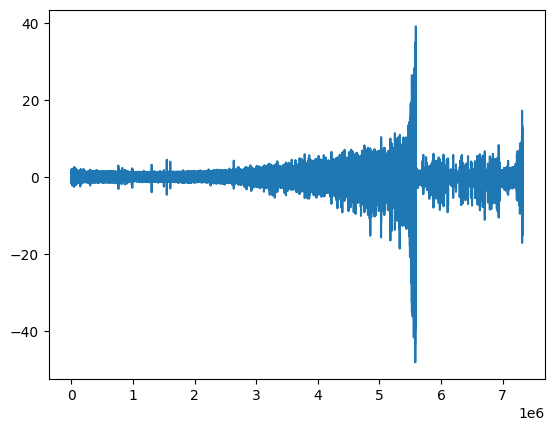

In [19]:
plt.plot(train_x[:, 0])

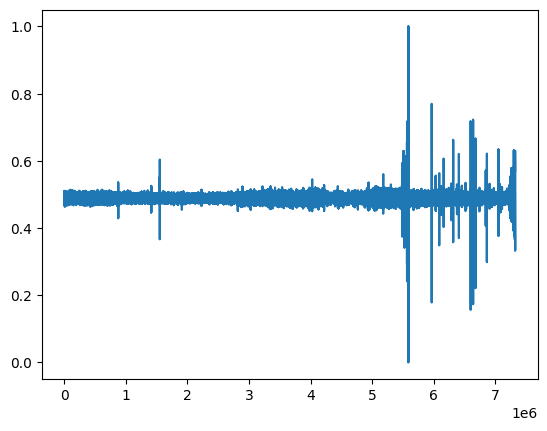

In [22]:
plt.plot(train_x[:, 1])

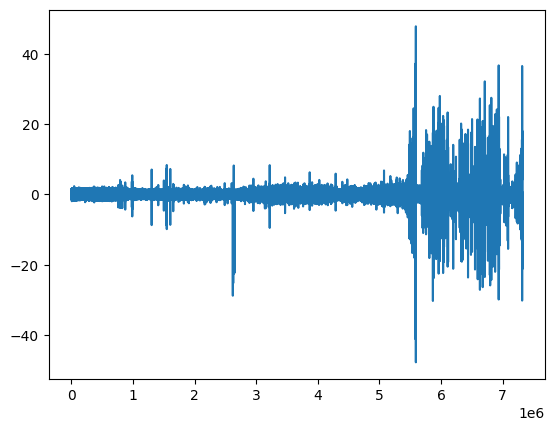

In [20]:
plt.plot(train_x[:, 1])

In [18]:
sio.savemat(f'./Mat_train/{condition}_2d_train_stride{stride}_x.mat', {"train_x": train_x})
sio.savemat(f'./Mat_train/{condition}_2d_train_stride{stride}_y.mat', {"train_y": train_y})

In [21]:
sio.savemat(f'./Mat_train/{condition}_3d_train_stride{stride}_x.mat', {"train_x": train_x})
sio.savemat(f'./Mat_train/{condition}_3d_train_stride{stride}_y.mat', {"train_y": train_y})

# Test

In [37]:
folder_type = 'Test_set'
bearing_folder = 'Bearing1_5'
acc_offset = accs_offset[bearing_folder]
temp_offset = temps_offset[bearing_folder]
test_life = {
    'Bearing1_3': 2375,
    'Bearing1_4': 1428,
    'Bearing1_5': 2463,
    'Bearing1_6': 2448,
    'Bearing1_7': 2259,
    'Bearing2_3': 1955,
    'Bearing2_4': 751,
    'Bearing2_5': 2311,
    'Bearing2_6': 701,
    'Bearing2_7': 230,
    'Bearing3_3': 434,
}
test_end = {
    'Bearing1_3': 1802,
    'Bearing1_4': 1139,
    'Bearing1_5': 2302,
    'Bearing1_6': 2302,
    'Bearing1_7': 1502,
    'Bearing2_3': 1202,
    'Bearing2_4': 612,
    'Bearing2_5': 2002,
    'Bearing2_6': 572,
    'Bearing2_7': 172,
    'Bearing3_3': 352,
}
test_rul = {
    'Bearing1_3': 573,
    'Bearing1_4': 289,
    'Bearing1_5': 161,
    'Bearing1_6': 146,
    'Bearing1_7': 757,
    'Bearing2_3': 753,
    'Bearing2_4': 139,
    'Bearing2_5': 309,
    'Bearing2_6': 129,
    'Bearing2_7': 58,
    'Bearing3_3': 82,
}

In [ ]:
csv_files = os.listdir(f'./{folder_type}/{bearing_folder}')
csv_files.sort()
acc_files = [acc for acc in csv_files if acc.startswith('acc')]
for i in range(1,acc_offset):
    remove_name = 'acc_' + str(i).zfill(5) + '.csv'
    acc_files.remove(remove_name)
temp_files = [temp for temp in csv_files if temp.startswith('temp')]

In [ ]:
test_x = []
test_y = []
max_window_stamp = 50
window_size = 40
test_acc = []
test_temp = []

In [ ]:
acc_file = acc_files[-1]
vibra = pd.read_csv(f'./{folder_type}/{bearing_folder}/{acc_file}',header=None,sep=',', usecols=[4,5])
for i in range(max_window_stamp):
    test_acc.append(vibra.iloc[i*stride:i*stride + window_size, :].values.tolist())
    test_y.append(573)

In [ ]:
test_x = np.array(test_acc)
len_x = len(test_x)
dim_x = test_x.shape[2]
test_x = test_x.reshape(-1, dim_x)
test_x = min_max_scaler.transform(test_x)
test_x = np.reshape(test_x,(len_x, 40, dim_x))

In [ ]:
sio.savemat(f'./Mat_test/{bearing_folder}_test_x.mat', {"test_x": test_x})
sio.savemat(f'./Mat_test/{bearing_folder}_test_y.mat', {"test_y": test_y})

In [ ]:
acc_file = acc_files[-1]
vibra = pd.read_csv(f'./{folder_type}/{bearing_folder}/{acc_file}',header=None,sep=',', usecols=[4,5])
test_acc.append(vibra.iloc[-window_size: , :].values.tolist())
# test_rul = len(acc_files) - acc_offset - stamp
test_y.append(34)

In [ ]:
temp_file = temp_files[-1]
temp_csv = pd.read_csv(f'./{folder_type}/{bearing_folder}/{temp_file}',header=None,sep=',', usecols=[4])
for i in range(max_window_stamp):
    temp = int(temp_csv.iloc[500 + temp_offset].values)
    temp_list = [temp] * 40
    test_temp.append(temp_list)

In [ ]:
temp_file = temp_files[-1]
temp_csv = pd.read_csv(f'./{folder_type}/{bearing_folder}/{temp_file}',header=None,sep=',', usecols=[4])
temp = int(temp_csv.iloc[500 + temp_offset].values)
temp_list = [temp] * 40
test_temp.append(temp_list)

In [ ]:
print(shape(test_acc))
# print(shape(test_temp))

In [ ]:
test_x = np.concatenate([test_acc, np.expand_dims(test_temp, axis=-1)], axis=-1)

In [ ]:
test_x = test_x.reshape(-1, 3)
test_x = min_max_scaler.transform(test_x)
test_x = np.reshape(test_x,(139800, 40, 3))

In [ ]:
print(shape(test_y))

In [ ]:
sio.savemat(f'./Mat_test/{bearing_folder}_test_x.mat', {"test_x": test_x})
sio.savemat(f'./Mat_test/{bearing_folder}_test_y.mat', {"test_y": test_y})

# Appendix

In [ ]:
testing = os.listdir('./Validation_Set/Full_Test_Set/')
testing.sort()
for f in testing:
    csv_files = os.listdir(f'./Validation_Set/Full_Test_Set/{f}')
    csv_files.sort()
    acc_files = [acc for acc in csv_files if acc.startswith('acc')]
    x = acc_files[-1].strip('.csv')
    number = re.split('_0*', x)
    print('\''+f+'\''+': '+number[-1]+',')

In [ ]:
d = pd.read_csv(f'./{folder_type}/{bearing_folder}/acc_00001.csv',header=None,sep=',', usecols=[4,5])
a = pd.DataFrame([[1,2,3], [4,5,6]])
b = a.iloc[0:2, 0:1]
print(type(b))

In [ ]:
print(len(train_temp))
print(shape(train_temp))

In [ ]:
print(shape(train_y))

In [ ]:
print(len(train_acc))
print(shape(train_acc))

In [ ]:
d = pd.read_csv('./Learning_set/Bearing1_1/acc_00001.csv',
            header=None,sep=',')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(d.iloc[:,-2])
plt.title('Horizontal_vibration_signals')
plt.subplot(122)
plt.plot(d.iloc[:,-1])
plt.title('Vertical_vibration_signals')
plt.show()

In [ ]:
def get_a_bearings_data(folder):
    ''' 获取某个工况下某个轴承的全部n个csv文件中的数据，返回numpy数组
    dp:bearings_x_x的folder
    return:folder下n个csv文件中的数据，shape:[n*32768,2]=[文件个数*采样点数，通道数]
    '''
    names = os.listdir(folder)
    is_acc = ['acc' in name for name in names] 
    names = names[:sum(is_acc)]
    files = [os.path.join(folder,f) for f in names]
    # Bearing1_4 的csv文件的分隔符是分号：';'
    print(pd.read_csv(files[0],header=None).shape)
    sep = ';' if pd.read_csv(files[0],header=None).shape[-1]==1 else ','
    h = [pd.read_csv(f,header=None,sep=sep).iloc[:,-2] for f in files]
    v = [pd.read_csv(f,header=None,sep=sep).iloc[:,-1] for f in files]
    H = np.concatenate(h)
    V = np.concatenate(v)
    print(H.shape,V.shape)
    return np.stack([H,V],axis=-1)

In [ ]:
p = 'D:\\ysu\\databank\\phm_data'

for i in ['Learning_set','Full_Test_Set']:
    pp = os.path.join(p,i)
    for j in os.listdir(pp):
        ppp = os.path.join(pp,j)
        print(ppp)
        data = get_a_bearings_data(ppp)
        save_name = p + '\\mat\\' + j+'.mat'
        print(save_name)
        scipy.io.savemat(save_name,{'h':data[:,0], 'v':data[:,1]}) # 写入mat文件        
    print('\n')

In [ ]:
#Import dataset
RUL_F001 = np.loadtxt('./Learn/Bearing1_1/')
train_F001 = np.loadtxt('./cmapss/train_FD001.txt')
test_F001 = np.loadtxt('./cmapss/test_FD001.txt')
train_F001[:, 2:] = min_max_scaler.fit_transform(train_F001[:, 2:])
test_F001[:, 2:] = min_max_scaler.transform(test_F001[:, 2:])
train_01_nor = train_F001
test_01_nor = test_F001
print(train_01_nor.shape)

In [ ]:
#Delete worthless sensors
train_01_nor = np.delete(train_01_nor, [5, 9, 10, 14, 20, 22, 23], axis=1) 
test_01_nor = np.delete(test_01_nor, [5, 9, 10, 14, 20, 22, 23], axis=1) 

In [ ]:
#parameters of data process
RUL_max = 125.0  
window_Size = 40 

trainX = []
trainY = []
trainY_bu = []
testX = []
testY = []
testY_bu = []
testInd = []
testLen = []
testX_all = []
testY_all = []
test_len = []

In [ ]:
# 取出1~編號上限的引擎
for i in range(1, int(np.max(train_01_nor[:, 0])) + 1):
    # 用np.where取出一個tuple, array存的是所有編號為i的引擎數據
    ind = np.where(train_01_nor[:, 0] == i)
    # 取出tuple 中的ndarray
    ind = ind[0]
    data_temp = train_01_nor[ind, :]
    for j in range(len(data_temp) - window_Size + 1): 
        trainX.append(data_temp[j:j + window_Size, 2:].tolist())
        # j+windowsize 代表目前time total-current=RUL
        train_RUL = len(data_temp) - window_Size - j
        # 看目前的rul跟max差多少
        train_bu = RUL_max - train_RUL
        if train_RUL > RUL_max:
            train_RUL = RUL_max
            train_bu = 0.0
        trainY.append(train_RUL)
        trainY_bu.append(train_bu)

In [ ]:
#Test set sliding time window processing
for i in range(1, int(np.max(test_01_nor[:, 0])) + 1):
    ind = np.where(test_01_nor[:, 0] == i)
    ind = ind[0]
    # 編號i的engine的total time
    testLen.append(float(len(ind)))
    data_temp = test_01_nor[ind, :]
    # 編號i的最後time step
    testY_bu.append(data_temp[-1, 1])
    if len(data_temp) < window_Size:
        
        data_temp_a = []
        # 特徵維度
        for myi in range(data_temp.shape[1]):
            # 根據 x數量 產生 0 ~ 40之間的x座標 
            x1 = np.linspace(0, window_Size - 1, len(data_temp))
            # 產生 0~40x座標
            x_new = np.linspace(0, window_Size - 1, window_Size)
            # 根據維度myi的點產生逼近函數
            tck = interpolate.splrep(x1, data_temp[:, myi])
            # 將0~40帶入tck產生的函數得y點
            a = interpolate.splev(x_new, tck)
            data_temp_a.append(a.tolist())
        data_temp_a = np.array(data_temp_a)
        data_temp = data_temp_a.T
        data_temp = data_temp[:, 2:]
    else:
        # test 只要最後四十個預測還有多少RUL即可
        data_temp = data_temp[-window_Size:, 2:]  
    # for concate usage extand 0th dimension
    data_temp = np.reshape(data_temp, (1, data_temp.shape[0], data_temp.shape[1])) 
    testX = data_temp if i == 1 else np.concatenate((testX, data_temp), axis=0)
    if RUL_F001[i - 1] > RUL_max:
        testY.append(RUL_max)
        #testY_bu.append(0.0)
    else:
        testY.append(RUL_F001[i - 1])

In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)/RUL_max 
trainY_bu = np.array(trainY_bu)/RUL_max
testY = np.array(testY)/RUL_max
testY_bu = np.array(testY_bu)/RUL_max

In [ ]:
print(trainX.shape)
print(trainY.shape)

In [ ]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

In [ ]:
sio.savemat('F001_window_size_trainX.mat', {"train1X": trainX})
sio.savemat('F001_window_size_trainY.mat', {"train1Y": trainY})
sio.savemat('F001_window_size_testX.mat', {"test1X": testX})
sio.savemat('F001_window_size_testY.mat', {"test1Y": testY})

In [ ]:
import scipy.io

mat = scipy.io.loadmat('F001_window_size_trainX.mat')
struct_array = mat['']
value = struct_array[0][0]['field_name']